In [1]:
import h2o
import operator
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
from matplotlib import pyplot as plt
import warnings
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators import H2OGradientBoostingEstimator
warnings.filterwarnings("ignore")

# 1 Data Preparation

## 1.1 H2O Initialization

In [2]:
pct_memory=4
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

37


In [3]:
h2o.init(strict_version_check=False,max_mem_size=min_mem_size)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "10.0.2" 2018-07-17; Java(TM) SE Runtime Environment 18.3 (build 10.0.2+13); Java HotSpot(TM) 64-Bit Server VM 18.3 (build 10.0.2+13, mixed mode)
  Starting server from /anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/5l/qqvypzcs2sjbbnhb777lxczh0000gn/T/tmptwrh2joi
  JVM stdout: /var/folders/5l/qqvypzcs2sjbbnhb777lxczh0000gn/T/tmptwrh2joi/h2o_mandy_started_from_python.out
  JVM stderr: /var/folders/5l/qqvypzcs2sjbbnhb777lxczh0000gn/T/tmptwrh2joi/h2o_mandy_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,"21 days, 14 hours and 57 minutes"
H2O cluster name:,H2O_from_python_mandy_v0rqbc
H2O cluster total nodes:,1
H2O cluster free memory:,37 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"accepting new members, healthy"


## 1.2 Data Import & Parse

In [4]:
data_path = "AmazonReviews.Small.csv"

# Load data into H2O
reviews = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [5]:
reviews.shape

(55554, 10)

In [6]:
reviews.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one."
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring."
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)"


In [7]:
print(reviews.types)

{'ProductId': 'enum', 'UserId': 'enum', 'Summary': 'enum', 'Score': 'int', 'HelpfulnessDenominator': 'int', 'Id': 'int', 'ProfileName': 'enum', 'HelpfulnessNumerator': 'int', 'Time': 'int', 'Text': 'string'}


In [8]:
reviews['PositiveReview']=(reviews['Score']>=reviews['Score'].mean()[0]).ifelse('1','0')

In [9]:
reviews['PositiveReview'].table()

PositiveReview,Count
0,20106
1,35448


In [10]:
# Find the 80th quantile of time in the dataset
time_split = reviews["Time"].quantile(prob = [0.8])[1]
reviews["Train"] = (reviews["Time"] < time_split).ifelse("Yes", "No")

In [11]:
reviews['Train'].table()

Train,Count
No,11152
Yes,44402


In [12]:
train = reviews[reviews["Train"] == "Yes"]
test = reviews[reviews["Train"] == "No"]

## 1.3 Tokenize Words in Review

In [13]:
data_path = "stopwords.csv"
STOP_WORDS = pd.read_csv(data_path, header=0)

In [14]:
STOP_WORDS.head()

,STOP_WORD
0,all
1,just
2,being
3,over
4,both


In [15]:
STOP_WORDS = list(STOP_WORDS['STOP_WORD'])

In [16]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [17]:
# Break reviews into sequence of words
words = tokenize(reviews["Text"])

In [18]:
words.head()

C1
made
china
buy
pet
food
china
dogswell
using
propylene
glycol


## 1.4 Word2Vec Model

In [19]:
# Train Word2Vec Model
from h2o.estimators.word2vec import H2OWord2vecEstimator


w2v_model = H2OWord2vecEstimator(vec_size = 100, model_id = "w2v.hex")
w2v_model.train(training_frame=words)

models_path='data'
h2o.save_model(w2v_model, path = models_path, force = True)

word2vec Model Build progress: |██████████████████████████████████████████| 100%


'/Users/mandy/Documents/Study/AI-Addin/data/w2v.hex'

In [20]:
# Sanity check - find synonyms for the word 'coffee'
w2v_model.find_synonyms("coffee", count = 5)

OrderedDict([('coffees', 0.7738841772079468),
             ('coffe', 0.7706735134124756),
             ('espresso', 0.7543292045593262),
             ('brew', 0.7464786767959595),
             ('decaf', 0.7248576879501343)])

In [21]:
# Sanity check - find synonyms for the word 'stale'
w2v_model.find_synonyms("stale", count = 5)

OrderedDict([('rancid', 0.6796302199363708),
             ('unedible', 0.6286389231681824),
             ('moldy', 0.6233909130096436),
             ('expired', 0.6204707026481628),
             ('tasteless', 0.6148790121078491)])

In [22]:
# Calculate a vector for each review
review_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")
review_vecs

C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
-0.0122179,-0.0502994,0.0218073,-0.0164256,0.0656912,0.0654515,0.0828205,-0.290214,0.101126,-0.0493187,-0.00657813,0.0555338,0.0792124,0.0862025,0.0570924,-0.113151,0.11962,-0.0701777,-0.185091,0.0567195,-0.0798927,-0.174119,0.17994,0.137418,0.212948,0.310326,0.0819299,0.107297,-0.13724,0.0275202,0.103236,0.149899,0.158365,-0.209154,-0.058551,0.103407,0.0855044,-0.0517969,0.0155602,-0.0373277,0.0484065,-0.0469061,0.028627,-0.10547,-0.0812122,0.0667717,0.028552,0.0907446,-0.0296406,0.089977,0.111156,0.0475175,0.0112141,0.0136322,0.00635814,-0.0597562,-0.0859784,0.0885865,-0.0434813,-0.0501226,-0.137153,0.183778,-0.185748,-0.165112,0.00767798,-0.0651262,0.0169025,0.0384777,0.0542043,0.118894,-0.0289208,-0.0138593,0.295354,0.131343,-0.0566233,0.0349508,0.00346211,0.115903,-0.0173776,-0.0946242,0.205655,0.038784,0.173744,0.122513,-0.0884568,-0.139343,0.063547,0.0585479,0.0103606,-0.013254,-0.0727496,0.00631874,-0.208654,0.0899552,-0.0041275,-0.0873403,-0.0595115,0.0643746,0.0183462,0.0306298
0.0954537,-0.00767106,-0.0844922,0.162538,0.0689488,0.0946931,0.0639001,-0.164788,0.0116408,0.0293042,0.116719,0.0832366,-0.0641017,0.0499295,0.00483758,0.0197933,0.106931,-0.0302717,-0.342306,0.0868531,0.0333891,-0.181619,0.161322,0.0415296,-0.115911,-0.000308342,-0.036611,0.242438,0.0779001,-0.0166447,-0.0263826,0.0880389,0.132673,-0.133066,-0.193412,0.00541177,0.0285736,-0.00442676,-0.0138734,-0.0893766,-0.0832792,-0.0364172,0.10606,-0.0468201,0.0140402,-0.0570401,-0.202029,-0.055616,-0.20974,-0.0110488,0.302709,-0.110085,0.21333,0.124271,0.126975,0.0758298,0.0352949,0.0118021,0.102881,0.108014,0.122041,0.213534,-0.146178,-0.0747106,0.0325057,-0.18518,0.0103385,-0.0377434,0.016926,-0.053162,0.011068,-0.0110801,0.13462,-0.0280283,0.103124,0.104072,0.0131332,0.0127396,-0.0219036,-0.0220267,-0.0581494,0.0462888,-0.0667474,0.154485,-0.0175949,-0.187092,0.0429194,0.130966,-0.0595529,0.00562216,-0.0984785,0.0664177,-0.127467,0.118053,0.0282033,-0.153154,-0.152386,0.0640156,-0.0868252,0.0543536
0.125585,-0.032561,0.0499473,0.13657,-0.0506283,-0.0656643,-0.0554537,-0.128319,0.119599,0.115325,0.0255238,0.0137678,0.00504837,0.134345,-0.0108781,0.0359491,0.116748,-0.104321,-0.0355232,-0.0182232,-0.15485,-0.111141,0.205746,0.0284322,0.120035,0.234782,0.0966786,0.0982171,-0.0588846,0.0195272,0.0443646,0.13264,0.188489,-0.207189,-0.142248,0.136291,0.195514,-0.00763438,0.0139827,-0.0615404,-0.0535333,-0.0740881,0.0501904,0.0447331,-0.172466,0.0127051,-0.0585925,-0.00254223,-0.0769085,0.00120073,0.155888,-0.0158356,0.0984369,-0.0195577,0.0605884,0.00314969,-0.0157124,-0.102743,-0.0874608,-0.0131776,-0.0191596,0.0865571,-0.0948878,-0.186816,-0.0289401,-0.105787,0.0467396,-0.0736471,0.152245,0.0546097,-0.0104541,-0.0582896,0.11861,0.0825033,-0.061094,0.114842,0.0799547,0.0996857,-0.201071,0.0527969,0.115182,0.0866911,0.00291924,0.205363,-0.0413777,-0.26016,0.119893,0.179649,-0.0667021,-0.00191906,-0.0521561,-0.00656414,-0.200034,0.152909,-0.0682311,0.0105146,-0.0681751,0.0273652,-0.0085692,0.0673636
0.084894,0.102162,0.032695,0.117447,0.0334458,0.00890081,-0.0568838,-0.0260828,0.173808,0.0406174,-0.0400031,0.0331566,-0.00825215,0.054047,-0.0315342,0.0576062,0.220391,-0.13426,-0.104354,-0.00459047,-0.161085,-0.209639,0.155888,0.136863,0.109215,0.136525,0.0407584,0.1744,-0.115676,0.0783245,0.0185375,0.121292,0.183182,-0.10312,-0.0784547,0.165448,0.123203,0.0209883,-0.0133621,-0.00380917,-0.114714,-0.101899,-0.0227697,0.106838,-0.0478078,-0.0409587,-0.146559,-0.092914,-0.0912436,-0.0098997,0.229528,-0.0299178,0.0655147,0.0555183,0.173495,-0.0577442,-0.0259936,-0.0498558,-0.149

In [23]:
# Add aggregated word embeddings 
ext_reviews = reviews.cbind(review_vecs)

In [24]:
ext_reviews.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,-0.0122179,-0.0502994,0.0218073,-0.0164256,0.0656912,0.0654515,0.0828205,-0.290214,0.101126,-0.0493187,-0.00657813,0.0555338,0.0792124,0.0862025,0.0570924,-0.113151,0.11962,-0.0701777,-0.185091,0.0567195,-0.0798927,-0.174119,0.17994,0.137418,0.212948,0.310326,0.0819299,0.107297,-0.13724,0.0275202,0.103236,0.149899,0.158365,-0.209154,-0.058551,0.103407,0.0855044,-0.0517969,0.0155602,-0.0373277,0.0484065,-0.0469061,0.028627,-0.10547,-0.0812122,0.0667717,0.028552,0.0907446,-0.0296406,0.089977,0.111156,0.0475175,0.0112141,0.0136322,0.00635814,-0.0597562,-0.0859784,0.0885865,-0.0434813,-0.0501226,-0.137153,0.183778,-0.185748,-0.165112,0.00767798,-0.0651262,0.0169025,0.0384777,0.0542043,0.118894,-0.0289208,-0.0138593,0.295354,0.131343,-0.0566233,0.0349508,0.00346211,0.115903,-0.0173776,-0.0946242,0.205655,0.038784,0.173744,0.122513,-0.0884568,-0.139343,0.063547,0.0585479,0.0103606,-0.013254,-0.0727496,0.00631874,-0.208654,0.0899552,-0.0041275,-0.0873403,-0.0595115,0.0643746,0.0183462,0.0306298
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as good as it is in the bags. Just considerably more bland -- less lemon and less zing. Boring.",0,Yes,0.0954537,-0.00767106,-0.0844922,0.162538,0.0689488,0.0946931,0.0639001,-0.164788,0.0116408,0.0293042,0.116719,0.0832366,-0.0641017,0.0499295,0.00483758,0.0197933,0.106931,-0.0302717,-0.342306,0.0868531,0.0333891,-0.181619,0.161322,0.0415296,-0.115911,-0.000308342,-0.036611,0.242438,0.0779001,-0.0166447,-0.0263826,0.0880389,0.132673,-0.133066,-0.193412,0.00541177,0.0285736,-0.00442676,-0.0138734,-0.0893766,-0.0832792,-0.0364172,0.10606,-0.0468201,0.0140402,-0.0570401,-0.202029,-0.055616,-0.20974,-0.0110488,0.302709,-0.110085,0.21333,0.124271,0.126975,0.0758298,0.0352949,0.0118021,0.102881,0.108014,0.122041,0.213534,-0.146178,-0.0747106,0.0325057,-0.18518,0.0103385,-0.0377434,0.016926,-0.053162,0.011068,-0.0110801,0.13462,-0.0280283,0.103124,0.104072,0.0131332,0.0127396,-0.0219036,-0.0220267,-0.0581494,0.0462888,-0.0667474,0.154485,-0.0175949,-0.187092,0.0429194,0.130966,-0.0595529,0.00562216,-0.0984785,0.0664177,-0.127467,0.118053,0.0282033,-0.153154,-0.152386,0.0640156,-0.0868252,0.0543536
B001PMCDK2,A14TTMM0Z03Y2W,my cat goes crazy for these!,5,0,389965,Lindsay S. Bradford,0,1.3106e+09,"Best cat treat ever. There isn't anything comparable to the love my cat has for these treats, he snubs away any other kind now.I know he likes to manipulate me with his cattiness but these treats are my way of manipulating him to come sit on my lap and have some chill time. :)",1,Yes,0.125585,-0.032561,0.0499473,0.13657,-0.0506283,-0.0656643,-0.0554537,-0.128319,0.119599,0.115325,0.0255238,0.0137678,0.00504837,0.134345,-0.0108781,0.0359491,0.116748,-0.104321,-0.0355232,-0.0182232,-0.15485,-0.111141,0.205746,0.0284322,0.120035,0.234782,0.0966786,0.0982171,-0.0588846,0.0195272,0.0443646,0.13264,0.188489,-0.207189,-0.142248,0.136291,0.195514,-0.00763438,0.0139827,-0.0615404,-0.0535333,-0.0740881,

## 1.5 Add Summary Column

In [25]:
# Break summaries into sequence of word.
summary_words = tokenize(reviews['Summary'].ascharacter())

In [26]:
summary_vecs = w2v_model.transform(summary_words, aggregate_method='AVERAGE')
summary_vecs.names = ['summary_'+ s for s in summary_vecs.names]

ext_reviews_new = ext_reviews.cbind(summary_vecs)

In [27]:
ext_reviews_new.head(3)

ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,PositiveReview,Train,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,summary_C1,summary_C2,summary_C3,summary_C4,summary_C5,summary_C6,summary_C7,summary_C8,summary_C9,summary_C10,summary_C11,summary_C12,summary_C13,summary_C14,summary_C15,summary_C16,summary_C17,summary_C18,summary_C19,summary_C20,summary_C21,summary_C22,summary_C23,summary_C24,summary_C25,summary_C26,summary_C27,summary_C28,summary_C29,summary_C30,summary_C31,summary_C32,summary_C33,summary_C34,summary_C35,summary_C36,summary_C37,summary_C38,summary_C39,summary_C40,summary_C41,summary_C42,summary_C43,summary_C44,summary_C45,summary_C46,summary_C47,summary_C48,summary_C49,summary_C50,summary_C51,summary_C52,summary_C53,summary_C54,summary_C55,summary_C56,summary_C57,summary_C58,summary_C59,summary_C60,summary_C61,summary_C62,summary_C63,summary_C64,summary_C65,summary_C66,summary_C67,summary_C68,summary_C69,summary_C70,summary_C71,summary_C72,summary_C73,summary_C74,summary_C75,summary_C76,summary_C77,summary_C78,summary_C79,summary_C80,summary_C81,summary_C82,summary_C83,summary_C84,summary_C85,summary_C86,summary_C87,summary_C88
B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1.34836e+09,"These are made in China (do not buy ANY pet food from China). Dogswell has been using propylene glycol to soften their treats (what are they thinkng?). Do not purchase or support this company in any way until they clean up their act. And for whatever reason Amazon doesn't allow returns of this item, so I had to toss mine out. Bad business all around on this one.",0,No,-0.0122179,-0.0502994,0.0218073,-0.0164256,0.0656912,0.0654515,0.0828205,-0.290214,0.101126,-0.0493187,-0.00657813,0.0555338,0.0792124,0.0862025,0.0570924,-0.113151,0.11962,-0.0701777,-0.185091,0.0567195,-0.0798927,-0.174119,0.17994,0.137418,0.212948,0.310326,0.0819299,0.107297,-0.13724,0.0275202,0.103236,0.149899,0.158365,-0.209154,-0.058551,0.103407,0.0855044,-0.0517969,0.0155602,-0.0373277,0.0484065,-0.0469061,0.028627,-0.10547,-0.0812122,0.0667717,0.028552,0.0907446,-0.0296406,0.089977,0.111156,0.0475175,0.0112141,0.0136322,0.00635814,-0.0597562,-0.0859784,0.0885865,-0.0434813,-0.0501226,-0.137153,0.183778,-0.185748,-0.165112,0.00767798,-0.0651262,0.0169025,0.0384777,0.0542043,0.118894,-0.0289208,-0.0138593,0.295354,0.131343,-0.0566233,0.0349508,0.00346211,0.115903,-0.0173776,-0.0946242,0.205655,0.038784,0.173744,0.122513,-0.0884568,-0.139343,0.063547,0.0585479,0.0103606,-0.013254,-0.0727496,0.00631874,-0.208654,0.0899552,-0.0041275,-0.0873403,-0.0595115,0.0643746,0.0183462,0.0306298,0.161865,-0.0929953,-0.102935,-0.0217129,0.052762,0.147362,-0.114468,-0.150282,0.277016,0.189779,0.0295461,0.260351,-0.027159,0.113816,0.178716,0.0990033,0.330658,0.0260945,-0.081406,0.0794582,0.144575,0.0497203,0.200064,0.262005,0.255146,0.151699,0.130417,0.281153,-0.0955602,-0.0428276,0.0406385,0.111282,0.122039,-0.23685,-0.113376,0.180925,0.203969,0.175042,-0.0782982,-0.0384024,0.308335,-0.267537,0.127193,0.179545,-0.0484078,-0.0524322,0.0413071,0.120321,-0.203257,0.212815,0.0161366,-0.093712,0.121656,-0.0459529,0.0248216,0.0535782,0.187371,0.0618226,-0.0666532,-0.0321787,-0.224544,0.500062,0.118816,0.0574585,-0.0568198,-0.0694349,0.0439924,-0.197363,-0.0716455,0.128095,0.0851593,-0.250005,0.306093,-0.0608246,0.0959114,5.90899e-05,0.111914,0.180868,0.260694,-0.198516,0.342787,0.0556378,0.134193,0.102734,0.173737,-0.106434,-0.0684863,0.0366764
B0089SPEO2,A3JOYNYL458QHP,Less lemon and less zing,3,0,28582,coleridge,0,1.32391e+09,"Everything is ok, except it just isn't as goo

In [28]:
ext_train_new = ext_reviews_new[ext_reviews_new["Train"] == "Yes"]
ext_test_new = ext_reviews_new[ext_reviews_new["Train"] == "No"]

In [29]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)

# 2 Training Models

## 2.1 Linear Regression

### 2.1.1 Train & Fit Model

In [30]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'] + summary_vecs.names + review_vecs.names 
response = 'PositiveReview'

In [31]:
# Initialize
local_glm_plus = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_surrogate', lambda_search=True)
# train 
local_glm_plus.train(x=predictors, y=response, training_frame=ext_train_new)

glm Model Build progress: |███████████████████████████████████████████████| 100%


In [32]:
type(local_glm_plus)

h2o.estimators.glm.H2OGeneralizedLinearEstimator

### 2.1.2 Interpretability

#### Variable Importance

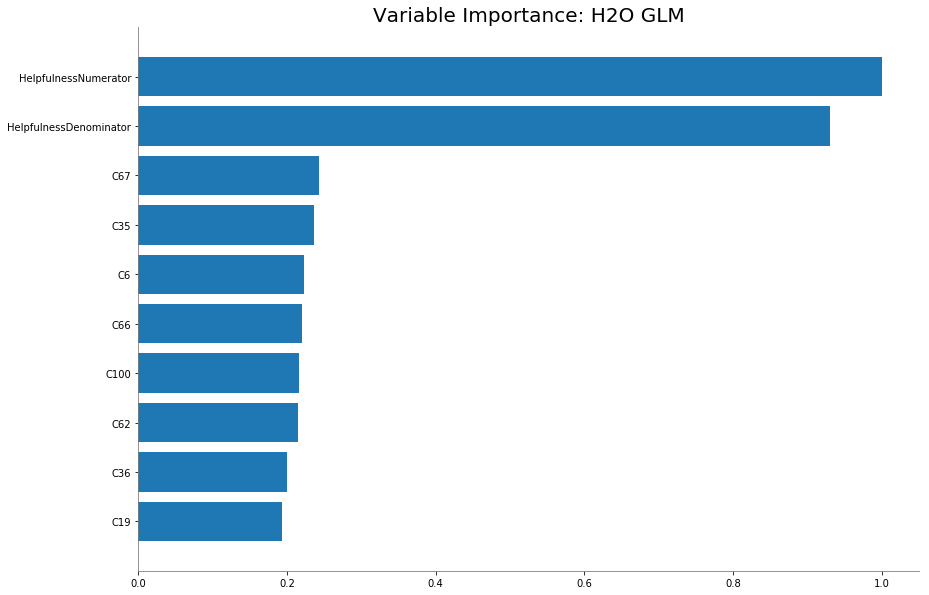

In [33]:
local_glm_plus.varimp_plot()

#### Partial Dependence Plot (PDP)

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


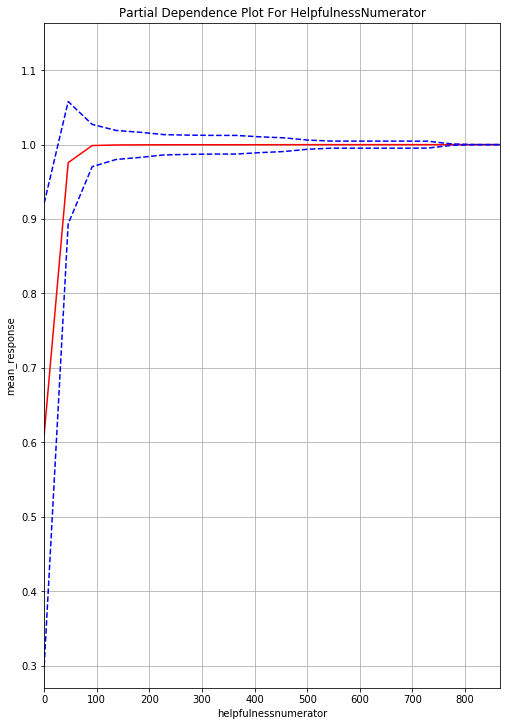

In [34]:
pdp_local_linear_plus = local_glm_plus.partial_plot(data = ext_train_new, cols = ["HelpfulnessNumerator"])

#### Individual Conditional Expectation (ICE)

In [37]:
import pandas
from io import StringIO
pandas.read_csv(StringIO(ext_test_new.get_frame_data()), low_memory=False, error_bad_lines=False)
ext_test_new_l = [row for row in csv.reader(StringIO(ext_test_new.get_frame_data()))]

b'Skipping line 3: expected 212 fields, saw 229\nSkipping line 6: expected 212 fields, saw 214\nSkipping line 16: expected 212 fields, saw 217\nSkipping line 17: expected 212 fields, saw 216\nSkipping line 21: expected 212 fields, saw 214\nSkipping line 26: expected 212 fields, saw 218\nSkipping line 32: expected 212 fields, saw 224\nSkipping line 39: expected 212 fields, saw 213\nSkipping line 55: expected 212 fields, saw 220\nSkipping line 73: expected 212 fields, saw 218\nSkipping line 74: expected 212 fields, saw 213\nSkipping line 78: expected 212 fields, saw 222\nSkipping line 106: expected 212 fields, saw 214\nSkipping line 114: expected 212 fields, saw 214\nSkipping line 116: expected 212 fields, saw 213\nSkipping line 120: expected 212 fields, saw 217\nSkipping line 133: expected 212 fields, saw 213\nSkipping line 136: expected 212 fields, saw 225\nSkipping line 137: expected 212 fields, saw 218\nSkipping line 141: expected 212 fields, saw 213\nSkipping line 145: expected 212 

In [38]:
lable = ext_test_new_l.pop(0)
lable

['ProductId',
 'UserId',
 'Summary',
 'Score',
 'HelpfulnessDenominator',
 'Id',
 'ProfileName',
 'HelpfulnessNumerator',
 'Time',
 'Text',
 'PositiveReview',
 'Train',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C15',
 'C16',
 'C17',
 'C18',
 'C19',
 'C20',
 'C21',
 'C22',
 'C23',
 'C24',
 'C25',
 'C26',
 'C27',
 'C28',
 'C29',
 'C30',
 'C31',
 'C32',
 'C33',
 'C34',
 'C35',
 'C36',
 'C37',
 'C38',
 'C39',
 'C40',
 'C41',
 'C42',
 'C43',
 'C44',
 'C45',
 'C46',
 'C47',
 'C48',
 'C49',
 'C50',
 'C51',
 'C52',
 'C53',
 'C54',
 'C55',
 'C56',
 'C57',
 'C58',
 'C59',
 'C60',
 'C61',
 'C62',
 'C63',
 'C64',
 'C65',
 'C66',
 'C67',
 'C68',
 'C69',
 'C70',
 'C71',
 'C72',
 'C73',
 'C74',
 'C75',
 'C76',
 'C77',
 'C78',
 'C79',
 'C80',
 'C81',
 'C82',
 'C83',
 'C84',
 'C85',
 'C86',
 'C87',
 'C88',
 'C89',
 'C90',
 'C91',
 'C92',
 'C93',
 'C94',
 'C95',
 'C96',
 'C97',
 'C98',
 'C99',
 'C100',
 'summary_C1',
 'summary_C2',
 'summary

In [39]:
ext_test_new_df = pd.DataFrame(ext_test_new_l)

In [40]:
ext_test_new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,274,275,276,277,278,279,280,281,282,283
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1348358400,These are made in China (do not buy ANY pet fo...,...,None,None,None,None,None,None,None,None,None,None
1,B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena doctorsirena""""",1,1343692800,"I am always looking for healthier, whole grain...",...,None,None,None,None,None,None,None,None,None,None
2,B001KUUNHE,A35R32TA60XD57,Best simple cat food,5,0,64358,M. Torma,0,1338940800,My cat that can eat fish loves this food! I w...,...,None,None,None,None,None,None,None,None,None,None
3,B009PFJUF2,A16HJRHRHNSUZ6,Looks very pretty when in bloom!,5,1,286942,Danielle Tietz,1,1350432000,My neighborhood recently decided to create a n...,...,None,None,None,None,None,None,None,None,None,None
4,B000SAPXPY,A3MQ68M8KRBUQH,Excellent flavor,5,2,368188,Claudia,2,1340928000,"I'm a big fan of good, strong British tea like...",...,None,None,None,None,None,None,None,None,None,None


In [41]:
# Check missing values' proportions
total = ext_test_new_df.isnull().sum()[ext_test_new_df.isnull().sum() != 0].sort_values(ascending = False)
percent = pd.Series(round(total/len(ext_test_new_df)*100,2))
pd.concat([total, percent], axis=1, keys=['total_missing', 'percent'])

,total_missing,percent
283,11151,99.99
272,11151,99.99
282,11151,99.99
265,11151,99.99
266,11151,99.99
267,11151,99.99
268,11151,99.99
269,11151,99.99
270,11151,99.99
271,11151,99.99


In [42]:
ext_test_new_df.dropna(axis=1, thresh=10000, inplace=True)

In [43]:
ext_test_new_df.head()

,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,210,211
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1348358400,These are made in China (do not buy ANY pet fo...,...,-0.07799235731363297,0.04839053750038147,-0.2585514783859253,0.07956297695636749,-0.26084616780281067,-0.021948721259832382,-0.18976007401943207,0.06214864179491997,-0.07712842524051666,0.3630388081073761
1,B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena doctorsirena""""",1,1343692800,"I am always looking for healthier, whole grain...",...,-0.058566685765981674,-0.04078615829348564,-0.009615098126232624,0.1831672340631485,0.09231755882501602,-0.15062372386455536,-0.10785698145627975,-0.10458847135305405,0.033932555466890335,0.028454169631004333
2,B001KUUNHE,A35R32TA60XD57,Best simple cat food,5,0,64358,M. Torma,0,1338940800,My cat that can eat fish loves this food! I w...,...,0.1150464341044426,0.0632527619600296,-0.20212548971176147,-0.0042395684868097305,-0.016022998839616776,-0.1292819380760193,0.014951806515455246,0.07544873654842377,0.08068554103374481,0.11795947700738907
3,B009PFJUF2,A16HJRHRHNSUZ6,Looks very pretty when in bloom!,5,1,286942,Danielle Tietz,1,1350432000,My neighborhood recently decided to create a n...,...,-0.10213299840688705,-0.06430958956480026,-0.08210942149162292,0.22349244356155396,0.13613520562648773,-0.2520558536052704,-0.04722695052623749,0.3063170611858368,-0.09244243055582047,0.01874682679772377
4,B000SAPXPY,A3MQ68M8KRBUQH,Excellent flavor,5,2,368188,Claudia,2,1340928000,"I'm a big fan of good, strong British tea like...",...,-0.11092902719974518,0.018857073038816452,-0.05005814880132675,0.20372338593006134,-0.10088235884904861,-0.042370252311229706,-0.11218608915805817,-0.08465956151485443,-0.05951784551143646,0.07531343400478363


In [44]:
ext_test_new_df.columns = lable

In [45]:
ext_test_new_df.head()

,ProductId,UserId,Summary,Score,HelpfulnessDenominator,Id,ProfileName,HelpfulnessNumerator,Time,Text,...,summary_C91,summary_C92,summary_C93,summary_C94,summary_C95,summary_C96,summary_C97,summary_C98,summary_C99,summary_C100
0,B00141QYSQ,A1YS02UZZGRDCT,Do Not Buy,1,2,41471,Evan Eberhardt,2,1348358400,These are made in China (do not buy ANY pet fo...,...,-0.07799235731363297,0.04839053750038147,-0.2585514783859253,0.07956297695636749,-0.26084616780281067,-0.021948721259832382,-0.18976007401943207,0.06214864179491997,-0.07712842524051666,0.3630388081073761
1,B0041CIR62,A16I6WJUEBJ1C3,okay but not as healthy as it appears,2,1,138997,"doctorsirena doctorsirena""""",1,1343692800,"I am always looking for healthier, whole grain...",...,-0.058566685765981674,-0.04078615829348564,-0.009615098126232624,0.1831672340631485,0.09231755882501602,-0.15062372386455536,-0.10785698145627975,-0.10458847135305405,0.033932555466890335,0.028454169631004333
2,B001KUUNHE,A35R32TA60XD57,Best simple cat food,5,0,64358,M. Torma,0,1338940800,My cat that can eat fish loves this food! I w...,...,0.1150464341044426,0.0632527619600296,-0.20212548971176147,-0.0042395684868097305,-0.016022998839616776,-0.1292819380760193,0.014951806515455246,0.07544873654842377,0.08068554103374481,0.11795947700738907
3,B009PFJUF2,A16HJRHRHNSUZ6,Looks very pretty when in bloom!,5,1,286942,Danielle Tietz,1,1350432000,My neighborhood recently decided to create a n...,...,-0.10213299840688705,-0.06430958956480026,-0.08210942149162292,0.22349244356155396,0.13613520562648773,-0.2520558536052704,-0.04722695052623749,0.3063170611858368,-0.09244243055582047,0.01874682679772377
4,B000SAPXPY,A3MQ68M8KRBUQH,Excellent flavor,5,2,368188,Claudia,2,1340928000,"I'm a big fan of good, strong British tea like...",...,-0.11092902719974518,0.018857073038816452,-0.05005814880132675,0.20372338593006134,-0.10088235884904861,-0.042370252311229706,-0.11218608915805817,-0.08465956151485443,-0.05951784551143646,0.07531343400478363


In [46]:
print(ext_test_new_df.dtypes)

ProductId                 object
UserId                    object
Summary                   object
Score                     object
HelpfulnessDenominator    object
Id                        object
ProfileName               object
HelpfulnessNumerator      object
Time                      object
Text                      object
PositiveReview            object
Train                     object
C1                        object
C2                        object
C3                        object
C4                        object
C5                        object
C6                        object
C7                        object
C8                        object
C9                        object
C10                       object
C11                       object
C12                       object
C13                       object
C14                       object
C15                       object
C16                       object
C17                       object
C18                       object
          

In [50]:
ext_test_new_df[['HelpfulnessNumerator']] = ext_test_new_df[['HelpfulnessNumerator']].astype(int)

ValueError: invalid literal for int() with base 10: ' MD canidate""'

glm prediction progress: |████████████████████████████████████████████████| 100%
   HelpfulnessNumerator  partial_dependence
0                   0.0            0.691535


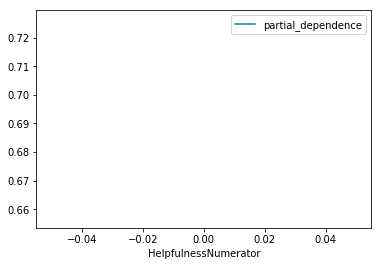

In [35]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas dataframe containing partial dependence for a single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Data for which to calculate partial dependence.
        model: Model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which to calculate partial dependence.
    
    Returns:
        Pandas dataframe containing partial dependence values.
        
    """
    
    # init empty Pandas frame w/ correct col names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original data 
    col_cache = h2o.deep_copy(frame[xs], xid='col_cache')
  
    # determine values at which to calculate partial dependency
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = max_ - min_/resolution
        bins = np.arange(min_, max_, by)
    # calculate partial dependency  
    # by setting column of interest to constant 
    for j in bins:
        frame[xs] = j
        par_dep_i = model.predict(frame)
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame[xs] = h2o.get_frame('col_cache')

    return par_dep_frame

# show some output
par_dep_HelpfulnessNumerator = par_dep('HelpfulnessNumerator', ext_test_new, local_glm_plus)
par_dep_HelpfulnessNumerator.plot.line(x='HelpfulnessNumerator', y='partial_dependence')
print(par_dep_HelpfulnessNumerator)

In [268]:
def get_quantile_dict(y, id_, frame):

    """ Returns the percentiles of a column y as the indices for another column id_.
    
    Args:
        y: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of y.
        frame: H2OFrame containing y and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    quantiles_df = frame
    quantiles_df.sort_values(y, inplace=True)
    quantiles_df.reset_index(inplace=True)
    
    percentiles_dict = {}
    percentiles_dict[0] = quantiles_df.loc[0, id_]
    percentiles_dict[99] = quantiles_df.loc[quantiles_df.shape[0]-1, id_]
    inc = quantiles_df.shape[0]//10
    
    for i in range(1, 10):
        percentiles_dict[i * 10] = quantiles_df.loc[i * inc,  id_]

    return percentiles_dict

quantile_dict = get_quantile_dict('PositiveReview', 'Id', ext_test_new_dfs)

In [ ]:
bins = list(par_dep_HelpfulnessNumerator['HelpfulnessNumerator'])
for i in sorted(quantile_dict.keys()):
    col_name = 'Percentile_' + str(i)
    par_dep_HelpfulnessNumerator[col_name] = par_dep('HelpfulnessNumerator', 
                                            ext_test_new[ext_test_new['Id'] == int(quantile_dict[i])], 
                                            local_glm_plus, 
                                            bins=bins)['partial_dependence']
par_dep_HelpfulnessNumerator

In [ ]:
def plot_par_dep_ICE(xs, par_dep_frame):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
    
    """
    
    # initialize figure and axis
    fig, ax = plt.subplots()
    
    # plot ICE curves
    par_dep_frame.drop('partial_dependence', axis=1).plot(x=xs, 
                                                          colormap='gnuplot',
                                                          ax=ax)

    # overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs),
                       x=xs, 
                       y='partial_dependence',
                       style='r-', 
                       linewidth=3, 
                       ax=ax)

    # add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)


In [ ]:
plot_par_dep_ICE('HelpfulnessNumerator', par_dep_HelpfulnessNumerator)

### 2.1.3 Matrix

In [169]:
print('\nLocal GLM Coefficients:')
for c_name, c_val in sorted(local_glm_plus.coef().items(), key=operator.itemgetter(1)):
    if c_val != 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))


Local GLM Coefficients:
C46:                      -4.260476800316235
C88:                      -3.0978936685560257
C22:                      -2.9655688628707715
C2:                       -2.9340255339304253
C13:                      -2.2511389050009414
C89:                      -2.1017036576949235
C49:                      -1.950408959025164
C32:                      -1.8707779174677097
C19:                      -1.8286575243501957
C12:                      -1.7966530610909817
C11:                      -1.700184340627838
C1:                       -1.6847025812196756
C82:                      -1.627829319697914
C83:                      -1.5565874726680813
C29:                      -1.5339705080817085
C35:                      -1.3521103076035348
C28:                      -1.3443180876656213
C33:                      -1.3318451299853227
C37:                      -1.2946954862022535
C59:                      -1.2792300066640068
C96:                      -1.2182719104519433
C92:         

In [170]:
local_glm_plus.r2(train=True, valid=True)

{'train': 0.432012638087628, 'valid': None}

In [171]:
local_glm_plus.auc()

0.8761496423028042

In [172]:
local_glm_plus.confusion_matrix()

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46039732571229414: 


,0,1,Error,Rate
0,10134.0,5760.0,0.3624,(5760.0/15894.0)
1,2269.0,26239.0,0.0796,(2269.0/28508.0)
Total,12403.0,31999.0,0.1808,(8029.0/44402.0)


## 2.2 Logistic Regression

### 2.2.1 Train & Fit Model

In [173]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'] + summary_vecs.names + review_vecs.names 
response = 'PositiveReview'

In [174]:
glm_logistic_plus_summary = H2OGeneralizedLinearEstimator(family = "binomial")
glm_logistic_plus_summary.train(x=predictors, 
                               y= response, 
                               training_frame = ext_train_new, 
                               validation_frame = ext_test_new, 
                               model_id="glm_logistic")

glm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.2.2 Interpretability

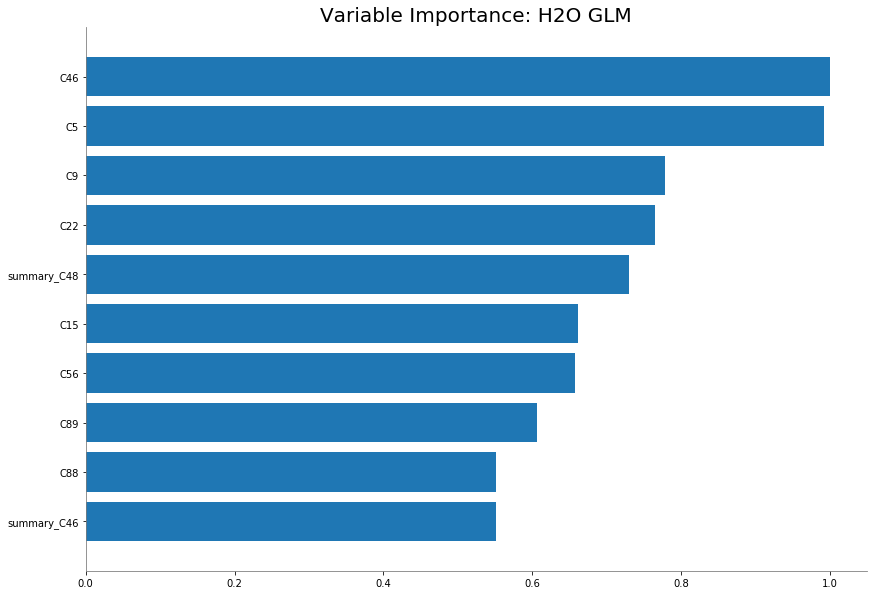

In [175]:
glm_logistic_plus_summary.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


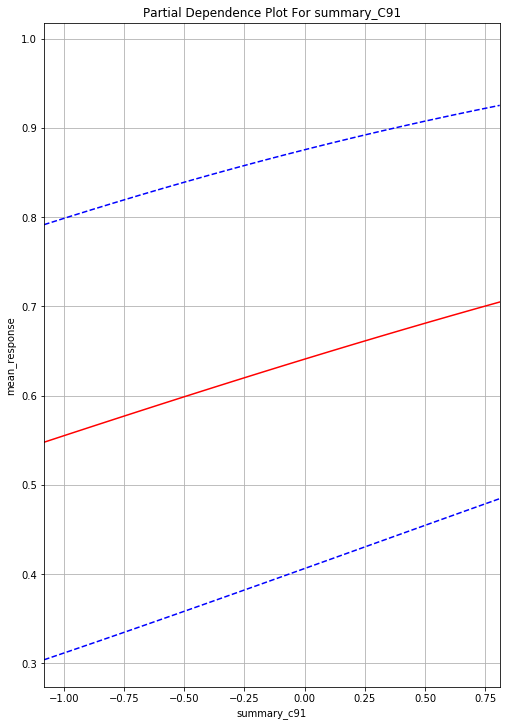

In [176]:
pdp_word_vecs = glm_logistic_plus_summary.partial_plot(data = ext_train_new, cols = ["summary_C91"])

### 2.2.3 Matrix

In [177]:
print("With Summary and Review Embeddings AUC: " + str(round(glm_logistic_plus_summary.auc(valid = True), 3)))

With Summary and Review Embeddings AUC: 0.854


In [178]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45977694654643286: 


,0,1,Error,Rate
0,2383.0,1829.0,0.4342,(1829.0/4212.0)
1,499.0,6441.0,0.0719,(499.0/6940.0)
Total,2882.0,8270.0,0.2088,(2328.0/11152.0)


In [179]:
glm_logistic_plus_summary.confusion_matrix(valid = True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45977694654643286: 


,0,1,Error,Rate
0,2383.0,1829.0,0.4342,(1829.0/4212.0)
1,499.0,6441.0,0.0719,(499.0/6940.0)
Total,2882.0,8270.0,0.2088,(2328.0/11152.0)


## 2.3 Decision Tree

In [180]:
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree
# in-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline

### 2.3.1 Train & Fit Model

In [181]:
predictors = ['ProductId', 'UserId', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'] + review_vecs.names + summary_vecs.names
response = 'PositiveReview'

In [182]:
# initialize single tree surrogate model
model_id = 'dt_surrogate_mojo'

# train single tree surrogate model
surrogate = H2OGradientBoostingEstimator(ntrees=1,
                                         sample_rate=1,
                                         col_sample_rate=1,
                                         max_depth=3,
                                         seed=12345,
                                         model_id=model_id)

_ = surrogate.train(x=predictors, y=response, training_frame=ext_train_new)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.3.2 Interpretability

### 2.3.3 Matrix

In [183]:
print(surrogate)

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  dt_surrogate_mojo


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.2243490810149944
RMSE: 0.47365502321309166
LogLoss: 0.6403868260777803
Mean Per-Class Error: 0.3404879658310178
AUC: 0.7002122496010603
pr_auc: 0.5469332774467338
Gini: 0.40042449920212064
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.6306127942269008: 


,0,1,Error,Rate
0,3105.0,12789.0,0.8046,(12789.0/15894.0)
1,1183.0,27325.0,0.0415,(1183.0/28508.0)
Total,4288.0,40114.0,0.3147,(13972.0/44402.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.6306128,0.7963918,6.0
max f2,0.6046605,0.8996806,7.0
max f0point5,0.6482974,0.7471640,3.0
max accuracy,0.6306128,0.6853295,6.0
max precision,0.6620901,0.8451599,0.0
max recall,0.6046605,1.0,7.0
max specificity,0.6620901,0.9065056,0.0
max absolute_mcc,0.6482974,0.3059479,3.0
max min_per_class_accuracy,0.6482974,0.6247369,3.0
max mean_per_class_accuracy,0.6482974,0.6595120,3.0


Gains/Lift Table: Avg response rate: 64.20 %, avg score: 64.19 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.2161389,0.6620901,1.3163600,1.3163600,0.8451599,0.6620901,0.8451599,0.6620901,0.2845166,0.2845166,31.6360036,31.6360036
,2,0.4462186,0.6528164,1.1718048,1.2418243,0.7523493,0.6529969,0.7973048,0.6574015,0.2696085,0.5541252,17.1804815,24.1824320
,3,0.5105401,0.6482974,1.0977953,1.2236785,0.7048319,0.6482974,0.7856544,0.6562545,0.0706118,0.6247369,9.7795267,22.3678528
,4,0.7076933,0.6337028,0.8707494,1.1253575,0.5590587,0.6337028,0.7225281,0.6499719,0.1716711,0.7964080,-12.9250557,12.5357514
,5,0.9034278,0.6306128,0.8281366,1.0609624,0.5316995,0.6309350,0.6811836,0.6458474,0.1620949,0.9585029,-17.1863358,6.0962375
,6,1.0,0.6046605,0.4297004,1.0,0.2758862,0.6046605,0.6420432,0.6418699,0.0414971,1.0,-57.0299608,0.0



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-22 05:00:54,0.010 sec,0.0,0.4793994,0.6522336,0.5,0.0,1.0,0.3579568
,2019-04-22 05:00:55,0.400 sec,1.0,0.4736550,0.6403868,0.7002122,0.5469333,1.3163600,0.3146705


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
C22,458.4889832,1.0,0.3602207
summary_C89,372.2006226,0.8117984,0.2924266
summary_C48,253.5211792,0.5529493,0.1991838
summary_C13,145.2473450,0.3167957,0.1141164
summary_C97,43.3419533,0.0945322,0.0340524
---,---,---,---
summary_C95,0.0,0.0,0.0
summary_C96,0.0,0.0,0.0
summary_C98,0.0,0.0,0.0
summary_C99,0.0,0.0,0.0



See the whole table with table.as_data_frame()



## 2.4 Gradient Boosting

### 2.4.1 Train & Fit Model

In [184]:
gbm = H2OGradientBoostingEstimator(stopping_metric = "AUC",
                                           stopping_tolerance = 0.001,
                                           stopping_rounds = 5, 
                                           score_tree_interval = 10, 
                                           model_id = 'gbm.hex')
gbm.train(x = predictors, 
                   y = response,
                  training_frame = ext_train_new,
                  validation_frame = ext_test_new)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


### 2.4.2 Interpretability

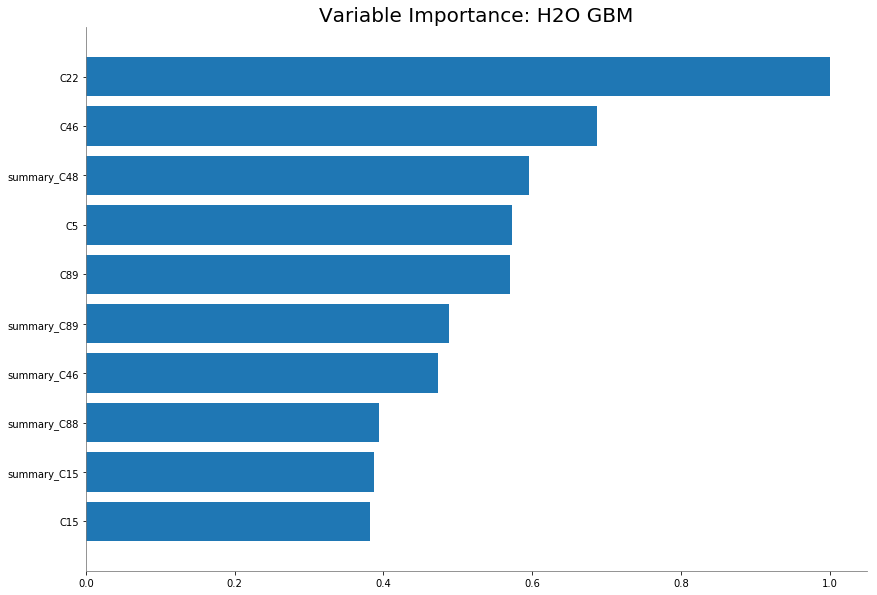

In [185]:
gbm.varimp_plot()

PartialDependencePlot progress: |█████████████████████████████████████████| 100%


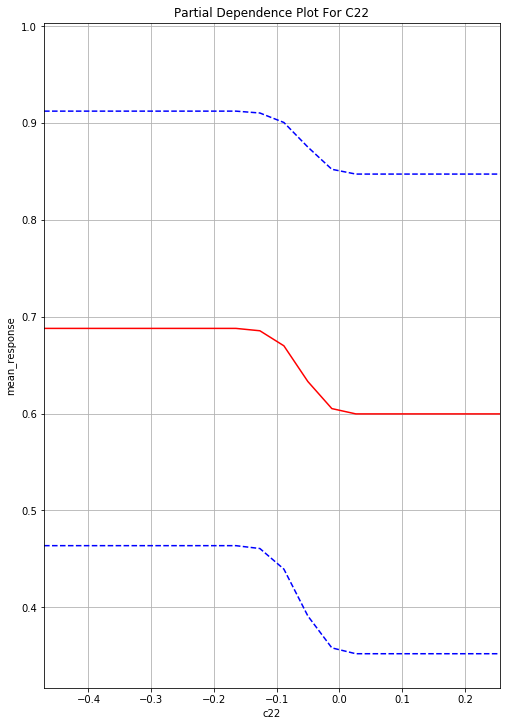

In [187]:
pdp_helpfulness = gbm.partial_plot(ext_train_new, cols = ['C22'])

In [198]:
def par_dep(xs, frame, model, resolution=20, bins=None):
    
    """ Creates Pandas dataframe containing partial dependence for a single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Data for which to calculate partial dependence.
        model: Model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which to calculate partial dependence.
    
    Returns:
        Pandas dataframe containing partial dependence values.
        
    """
    
    # init empty Pandas frame w/ correct col names
    par_dep_frame = pd.DataFrame(columns=[xs, 'partial_dependence'])
    
    # cache original data 
    col_cache = h2o.deep_copy(frame[xs], xid='col_cache')
  
    # determine values at which to calculate partial dependency
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependency  
    # by setting column of interest to constant 
    for j in bins:
        frame[xs] = j
        par_dep_i = model.predict(frame)
        par_dep_j = par_dep_i.mean()[0]
        par_dep_frame = par_dep_frame.append({xs:j,
                                              'partial_dependence': par_dep_j}, 
                                              ignore_index=True)
        
    # return input frame to original cached state    
    frame[xs] = h2o.get_frame('col_cache')

    return par_dep_frame

# show some output
par_dep_HelpfulnessNumerator = par_dep('HelpfulnessNumerator', ext_test_new, local_glm_plus)
par_dep_HelpfulnessNumerator.plot.line(x='HelpfulnessNumerator', y='partial_dependence')
print(par_dep_HelpfulnessNumerator)

glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |████████████████████████████████████████████████| 100%
glm prediction progress: |██

In [202]:
quantile_dict = get_quantile_dict('PositiveReview', 'Id', ext_test_new)

H2OResponseError: Server error java.lang.IllegalArgumentException:
  Error: Row slicing requires a number-list as the last argument, but found a class water.rapids.ast.params.AstStr
  Request: POST /99/Rapids
    data: {'ast': "(tmp= py_578_sid_803f (rows (cols_py py_574_sid_803f 'Id') 'PositiveReview'))", 'session_id': '_sid_803f'}


### 2.4.3 Matrix

In [47]:
print("AUC on validation data: " + str(round(gbm.auc(valid = True), 3)))

AUC on validation data: 0.846


In [48]:
gbm.confusion_matrix(valid=True)

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47887123153948047: 


,0,1,Error,Rate
0,2446.0,1766.0,0.4193,(1766.0/4212.0)
1,555.0,6385.0,0.08,(555.0/6940.0)
Total,3001.0,8151.0,0.2081,(2321.0/11152.0)


In [49]:
gbm.r2(train=True, valid=True)

{'train': 0.44591204451732713, 'valid': 0.357253899124959}

In [135]:
h2o.cluster().shutdown()

H2O session _sid_867b closed.
